In [1]:
import os
import pickle
import sys
from glob import glob

import climlab
import fedrl_climate_envs
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import xarray as xr
from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.gridspec import GridSpec

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
VIDEOS_DIR = f"{BASE_DIR}/videos"

NUM_STEPS = 200

sys.path.append(BASE_DIR)

In [3]:
fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

climlab_ebm = climlab.EBM_annual(num_lat=96)
climlab_ebm.Ts[:] = 50.0
Ts_ncep_annual = Ts_ncep_annual.interp(
    lat=climlab_ebm.lat, kwargs={"fill_value": "extrapolate"}
)
Ts_ncep_annual = np.array(Ts_ncep_annual)

climlab_ebm_temps = [np.array(climlab_ebm.Ts)]
for i in range(NUM_STEPS):
    climlab_ebm.step_forward()
    climlab_ebm_temps.append(np.array(climlab_ebm.Ts))
climlab_ebm_temps = np.array(climlab_ebm_temps).squeeze()

Loading NCEP surface temperature data ...


In [4]:
EXPERIMENT_ID = "ebm-v2-optim-L-20k-a6-fed05"
ALGO = "ddpg"
SEED = 1
NUM_CLIENTS = 6

EBM_LATITUDES = 96
EBM_SUBLATITUDES = EBM_LATITUDES // NUM_CLIENTS

CLIENT_IDS = [x for x in range(NUM_CLIENTS)]

record_fns = sorted(
    glob(
        RECORDS_DIR
        + f"/infx10_*{EXPERIMENT_ID}_*/*_{ALGO}_torch__{SEED}__*/*_200.pth"
    )
)

In [5]:
def get_record_row(record_fn, strip=True):
    with open(record_fn, "rb") as f:
        record_steps = torch.load(f)
        cid = int(record_fn.split("/")[-2].split("__")[-2])
        obs = record_steps["obs"]

        if strip == True:
            ebm_min_idx, ebm_max_idx = (
                cid * EBM_SUBLATITUDES,
                (cid + 1) * EBM_SUBLATITUDES,
            )
            obs = obs[:, ebm_min_idx:ebm_max_idx]
            lat = climlab_ebm.lat[ebm_min_idx:ebm_max_idx]

        return {"cid": cid, "obs": obs, "lat": lat}


records = [get_record_row(x) for x in record_fns]
ebm_Ts = np.array(
    [
        np.concatenate([x["obs"][idx] for x in records], axis=0)
        for idx in range(len(records[0]["obs"]))
    ]
)
blats = [np.ceil(x["lat"][-1]) for x in records][:-1]

In [6]:
def plot_ebmTs(
    ebm_Tst=None,
    ebm_Ts=None,
    climlab_ebm_temps=None,
    movie=False,
    out_path=None,
):
    fig = plt.figure(figsize=(18, 8))
    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])

    if movie:
        (change1,) = ax1.plot([], [], label="EBM Model w/ RL")
        (change2,) = ax1.plot([], [], label="EBM Model")
    else:
        ax1.plot(climlab_ebm.lat, ebm_Tst, label="EBM Model w/ RL")
        ax1.plot(climlab_ebm.lat, climlab_ebm.Ts, label="EBM Model")

    ax1.plot(
        climlab_ebm.lat,
        Ts_ncep_annual,
        label="Observations",
        c="k",
    )
    ax1.set_ylabel("Temperature (°C)")
    ax1.set_xlabel("Latitude")
    ax1.set_xlim(-90, 90)
    ax1.set_xticks(np.arange(-90, 91, 30))
    ax1.legend()
    ax1.grid()

    # for blat in blats:
    #     ax1.axvline(x=blat, color='k', linestyle='--', linewidth=1)

    ax2 = fig.add_subplot(gs[0, 1])
    if movie:
        change3 = ax2.bar(
            x=climlab_ebm.lat,
            height=np.zeros_like(climlab_ebm.lat),
            label="EBM Model w/ RL",
        )
        change4 = ax2.bar(
            x=climlab_ebm.lat,
            height=np.zeros_like(climlab_ebm.lat),
            label="EBM Model",
            zorder=-1,
        )
    else:
        ax2.bar(
            x=climlab_ebm.lat,
            height=np.abs(ebm_Tst - Ts_ncep_annual),
            label="EBM Model w/ RL",
        )
        ax2.bar(
            x=climlab_ebm.lat,
            height=np.abs(climlab_ebm.Ts.reshape(-1) - Ts_ncep_annual),
            label="EBM Model",
            zorder=-1,
        )

    ax2.set_ylabel("Error  (°C)")
    ax2.set_xlabel("Latitude")
    ax2.set_xlim(-90, 90)
    ax2.set_xticks(np.arange(-90, 91, 30))
    ax2.legend()
    ax2.grid()

    # for blat in blats:
    #     ax2.axvline(x=blat, color='k', linestyle='--', linewidth=1)

    def update(idx):
        ebm_Tst = ebm_Ts[idx]
        climlab_ebm_temp = climlab_ebm_temps[idx]

        change1.set_data(climlab_ebm.lat, ebm_Tst)
        change2.set_data(climlab_ebm.lat, climlab_ebm_temp)
        ymin = (
            min(ebm_Tst.min(), climlab_ebm_temp.min(), Ts_ncep_annual.min())
            - 2
        )
        ymax = (
            max(ebm_Tst.max(), climlab_ebm_temp.max(), Ts_ncep_annual.max())
            + 2
        )
        ax1.set_ylim(ymin, ymax)

        for rect, h in zip(change3, np.abs(ebm_Tst - Ts_ncep_annual)):
            rect.set_height(h)
        for rect, h in zip(change4, np.abs(climlab_ebm_temp - Ts_ncep_annual)):
            rect.set_height(h)

        max_error = max(
            np.abs(ebm_Tst - Ts_ncep_annual).max(),
            np.abs(climlab_ebm_temp - Ts_ncep_annual).max(),
        )
        ax2.set_ylim(0, max_error + 2)

        return [change1] + [change2] + list(change3) + list(change4)

    if movie:
        anim = FuncAnimation(
            fig, update, frames=len(ebm_Ts), interval=1000 / 30, blit=True
        )
        writer = FFMpegWriter(fps=30, bitrate=1800)
        anim.save(out_path, writer=writer)
        plt.close()

AWRMSE: 3.8851145548124566


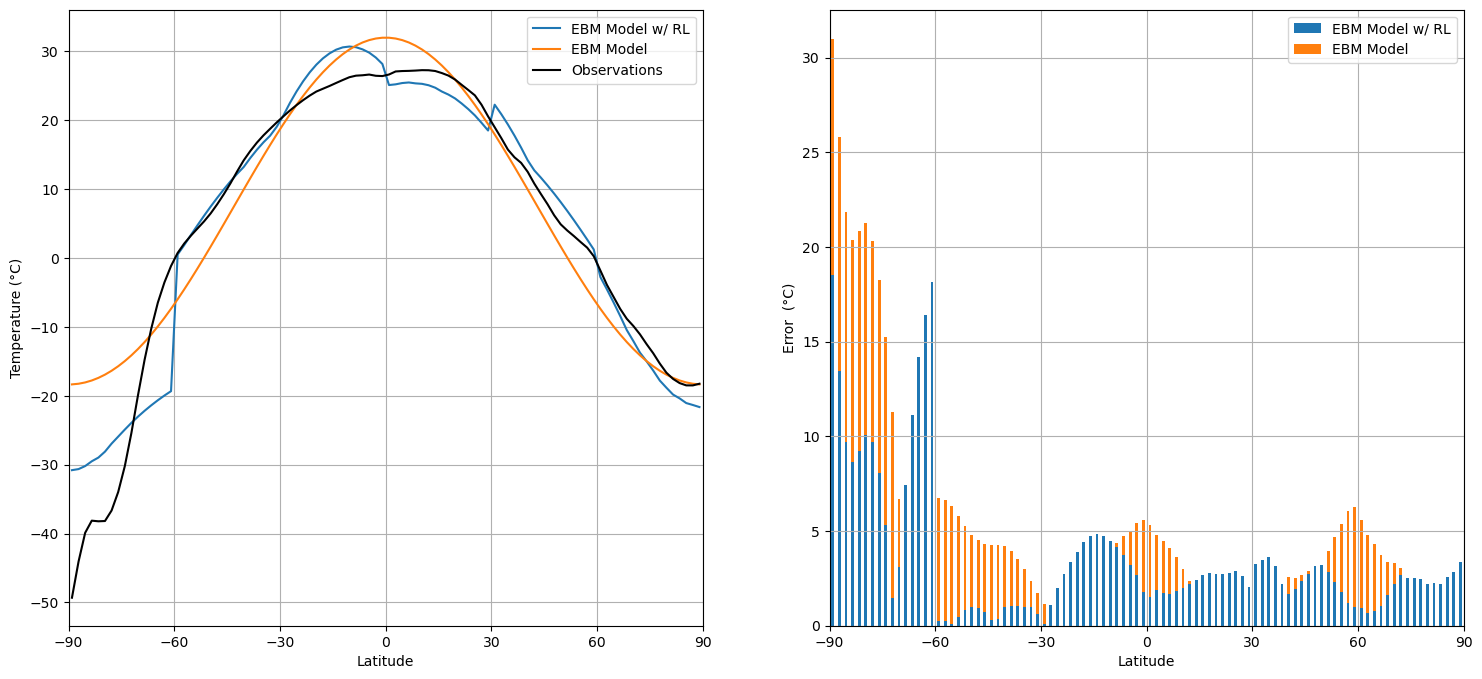

In [7]:
def area_weighted_rmse(error, latitudes):
    weights = np.cos(np.radians(latitudes))
    weights /= weights.sum()
    return np.sqrt(np.average(error**2, weights=weights))


plot_ebmTs(ebm_Tst=ebm_Ts[-1])
print(
    "AWRMSE:", area_weighted_rmse(ebm_Ts[-1] - Ts_ncep_annual, climlab_ebm.lat)
)

In [8]:
exp_dir = f"{VIDEOS_DIR}/{record_fns[0].split('/')[-3]}"

video_folder = "__".join(
    record_fns[0].split("/")[-2].split("__")[:-2] + ["combined"]
)
video_folder = f"{exp_dir}/{video_folder}"
os.makedirs(video_folder, exist_ok=True)

out_path = f"{video_folder}/rl-video-episode-0.mp4"
plot_ebmTs(
    ebm_Ts=ebm_Ts,
    movie=True,
    climlab_ebm_temps=climlab_ebm_temps,
    out_path=out_path,
)